In [1]:
from google.colab import files
uploaded = files.upload()


Saving advanced_financial_dataset.csv to advanced_financial_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

df.head()


,account_id,loan_amount,interest_rate,credit_score,payment_history,balance,region,last_transaction_amount,age,income,account_type
0,1,46410.93,4.14,642,"[0, 0, 0, 1, 0]",45410.93,British Columbia,406.38,68,82666.72,Business
1,2,166784.04,4.43,593,"[1, 0, 0, 0, 0]",165784.04,Alberta,1601.20,33,38887.82,Business
2,3,37388.54,5.69,715,"[0, 0, 1, 0, 0]",36388.54,British Columbia,1200.80,68,70207.36,Business
3,4,56830.03,7.84,469,"[0, 0, 0, 0, 0]",56830.03,Ontario,1240.13,39,113440.29,Business
4,5,80589.79,3.98,667,"[0, 0, 0, 0, 0]",80589.79,Alberta,998.72,58,69043.87,Business


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account_id               1000 non-null   int64  
 1   loan_amount              1000 non-null   float64
 2   interest_rate            1000 non-null   float64
 3   credit_score             1000 non-null   int64  
 4   payment_history          1000 non-null   object 
 5   balance                  1000 non-null   float64
 6   region                   1000 non-null   object 
 7   last_transaction_amount  1000 non-null   float64
 8   age                      1000 non-null   int64  
 9   income                   1000 non-null   float64
 10  account_type             1000 non-null   object 
dtypes: float64(5), int64(3), object(3)
memory usage: 86.1+ KB


In [5]:
data_quality = {
    "Total Rows": df.shape[0],
    "Total Columns": df.shape[1],
    "Missing Values": df.isnull().sum(),
    "Duplicate Rows": df.duplicated().sum()
}

data_quality


{'Total Rows': 1000,
 'Total Columns': 11,
 'Missing Values': account_id                 0
 loan_amount                0
 interest_rate              0
 credit_score               0
 payment_history            0
 balance                    0
 region                     0
 last_transaction_amount    0
 age                        0
 income                     0
 account_type               0
 dtype: int64,
 'Duplicate Rows': np.int64(0)}

In [6]:
numeric_df = df.select_dtypes(include=["int64", "float64"])
numeric_df.head()


,account_id,loan_amount,interest_rate,credit_score,balance,last_transaction_amount,age,income
0,1,46410.93,4.14,642,45410.93,406.38,68,82666.72
1,2,166784.04,4.43,593,165784.04,1601.20,33,38887.82
2,3,37388.54,5.69,715,36388.54,1200.80,68,70207.36
3,4,56830.03,7.84,469,56830.03,1240.13,39,113440.29
4,5,80589.79,3.98,667,80589.79,998.72,58,69043.87


In [8]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=100,
    contamination=0.03,
    random_state=42
)

numeric_df["anomaly_flag"] = model.fit_predict(numeric_df)
numeric_df["is_anomaly"] = numeric_df["anomaly_flag"].apply(lambda x: 1 if x == -1 else 0)

numeric_df.head()


,account_id,loan_amount,interest_rate,credit_score,balance,last_transaction_amount,age,income,anomaly_flag,is_anomaly
0,1,46410.93,4.14,642,45410.93,406.38,68,82666.72,1,0
1,2,166784.04,4.43,593,165784.04,1601.20,33,38887.82,1,0
2,3,37388.54,5.69,715,36388.54,1200.80,68,70207.36,1,0
3,4,56830.03,7.84,469,56830.03,1240.13,39,113440.29,1,0
4,5,80589.79,3.98,667,80589.79,998.72,58,69043.87,1,0


In [9]:
amount_column = numeric_df.columns[0]

numeric_df["account_avg"] = numeric_df[amount_column].mean()
numeric_df["amount_99"] = numeric_df[amount_column].quantile(0.99)


In [10]:
def ai_explanation(row):
    if row["is_anomaly"] == 1:
        return (
            "This record shows an unusually high value compared to normal behavior. "
            "It exceeds typical operational ranges and falls beyond established thresholds, "
            "indicating a potential data integrity or risk concern."
        )
    else:
        return "This record falls within expected operational limits."

numeric_df["ai_explanation"] = numeric_df.apply(ai_explanation, axis=1)

numeric_df[["ai_explanation"]].head()


,ai_explanation
0,This record falls within expected operational ...
1,This record falls within expected operational ...
2,This record falls within expected operational ...
3,This record falls within expected operational ...
4,This record falls within expected operational ...


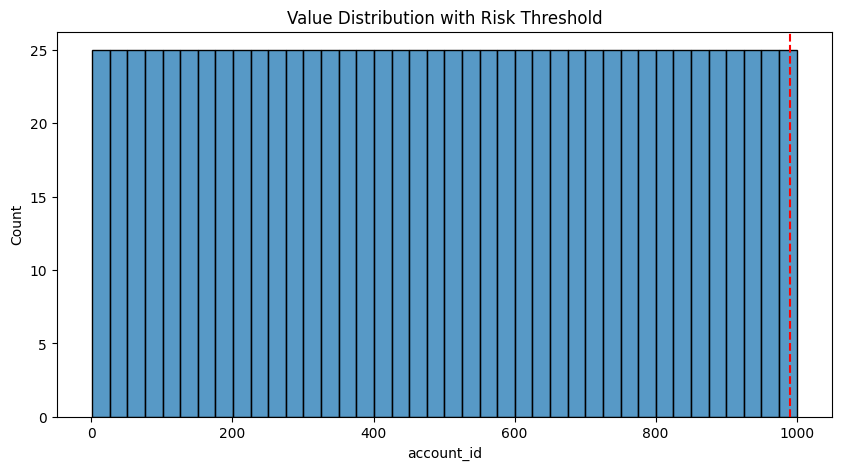

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(numeric_df[amount_column], bins=40)
plt.axvline(numeric_df["amount_99"].iloc[0], color="red", linestyle="--")
plt.title("Value Distribution with Risk Threshold")
plt.show()


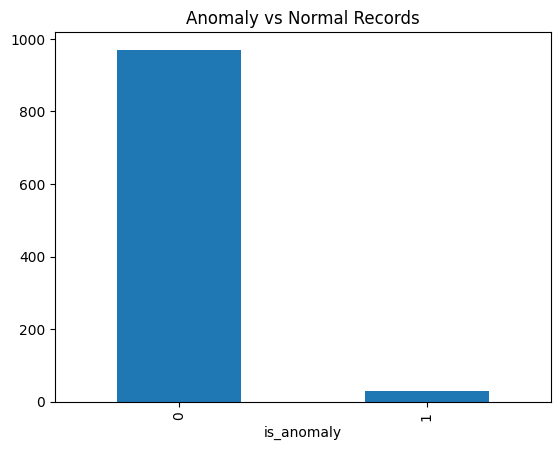

In [18]:
import matplotlib.pyplot as plt

final_df["is_anomaly"].value_counts().plot(kind="bar")
plt.title("Anomaly vs Normal Records")
plt.show()


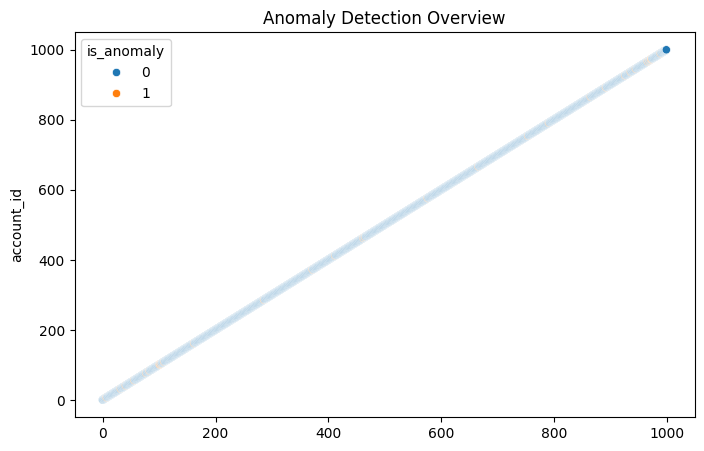

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=range(len(numeric_df)),
    y=numeric_df[amount_column],
    hue=numeric_df["is_anomaly"]
)
plt.title("Anomaly Detection Overview")
plt.show()


In [12]:
final_df = pd.concat(
    [df.reset_index(drop=True),
     numeric_df[["is_anomaly", "ai_explanation"]].reset_index(drop=True)],
    axis=1
)

final_df.head()


,account_id,loan_amount,interest_rate,credit_score,payment_history,balance,region,last_transaction_amount,age,income,account_type,is_anomaly,ai_explanation
0,1,46410.93,4.14,642,"[0, 0, 0, 1, 0]",45410.93,British Columbia,406.38,68,82666.72,Business,0,This record falls within expected operational ...
1,2,166784.04,4.43,593,"[1, 0, 0, 0, 0]",165784.04,Alberta,1601.20,33,38887.82,Business,0,This record falls within expected operational ...
2,3,37388.54,5.69,715,"[0, 0, 1, 0, 0]",36388.54,British Columbia,1200.80,68,70207.36,Business,0,This record falls within expected operational ...
3,4,56830.03,7.84,469,"[0, 0, 0, 0, 0]",56830.03,Ontario,1240.13,39,113440.29,Business,0,This record falls within expected operational ...
4,5,80589.79,3.98,667,"[0, 0, 0, 0, 0]",80589.79,Alberta,998.72,58,69043.87,Business,0,This record falls within expected operational ...


In [13]:
final_df.to_csv("ai_data_quality_output.csv", index=False)


In [14]:
final_df["is_anomaly"].value_counts()


,count
is_anomaly,
0,970
1,30


In [17]:
print("Sample flagged records:")
final_df[final_df["is_anomaly"] == 1].head(10)



Sample flagged records:


,account_id,loan_amount,interest_rate,credit_score,payment_history,balance,region,last_transaction_amount,age,income,account_type,is_anomaly,ai_explanation
7,8,63512.37,8.98,511,"[0, 0, 0, 1, 1]",61512.37,British Columbia,306.51,47,22489.48,Business,1,This record shows an unusually high value comp...
32,33,183716.63,6.80,734,"[0, 1, 0, 0, 0]",182716.63,Alberta,2328.24,67,114126.99,Mortgage,1,This record shows an unusually high value comp...
41,42,126413.89,3.57,776,"[0, 0, 1, 0, 0]",125413.89,British Columbia,4856.72,70,92199.99,Mortgage,1,This record shows an unusually high value comp...
56,57,139801.75,5.57,671,"[0, 0, 0, 0, 0]",139801.75,Alberta,-1468.62,22,129095.54,Business,1,This record shows an unusually high value comp...
77,78,241454.96,2.93,672,"[0, 0, 1, 0, 0]",240454.96,Quebec,1888.80,27,65266.19,Personal,1,This record shows an unusually high value comp...
83,84,152747.97,2.78,726,"[1, 0, 1, 0, 0]",150747.97,Manitoba,652.18,69,13510.79,Business,1,This record shows an unusually high value comp...
101,102,98856.28,8.84,488,"[0, 0, 0, 0, 0]",98856.28,Ontario,3078.08,42,141706.48,Personal,1,This record shows an unusually high value comp...
102,103,-10707.05,4.73,680,"[0, 0, 0, 0, 0]",-10707.05,Ontario,1261.38,21,116946.65,Business,1,This record shows an unusually high value comp...
104,105,15338.98,8.47,557,"[0, 1, 0, 0, 0]",14338.98,Manitoba,3869.28,57,32216.49,Mortgage,1,This record shows an unusually high value comp...
109,110,117712.23,4.41,753,"[0, 0, 0, 1, 0]",116712.23,Manitoba,4209.08,23,9818.27,Personal,1,This record shows an unusually high value comp...
